# Polarization reconstruction with PyREx

### Nov 19, 2020

In [2]:
import sys
import csv
# sys.path.insert(0,"/users/PCON0003/cond0068/.local/lib/python3.7/")
sys.path.append("/users/PAS0654/osu8354/ARA_cvmfs/root_build/lib/") # go to parent dir
sys.path.append("/users/PCON0003/cond0068/.local/lib/python3.7/site-packages/")
# sys.path.append("/users/PCON0003/cond0068/pyrex_sims/fromBen/thesis_work/pyrex-custom/analysis/custom/analysis/")
import ROOT
import math
import numpy as np
from ROOT import TH1D,TF1, gRandom, gPad, gStyle
import matplotlib as mpl
import matplotlib.pyplot as plt
from ROOT import TChain, TSelector, TTree
import os
import matplotlib.colors as mcolors
import scipy
from matplotlib.colors import LogNorm
import pandas as pd
import pyrex
import seaborn as sns
%matplotlib inline
sys.path.insert(1, "/users/PAS0654/osu8354/ARA_cvmfs/source/AraRoot/analysis/ARA_analysis/CenA_sourceSearch/Stokes")
import deDisperse_util as util
from pyrex.internal_functions import normalize
my_path_plots = os.path.abspath("./plots/")

Welcome to JupyROOT 6.18/04


In [3]:
# mpl.use('agg') 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.unicode'] = True
mpl.rcParams['mathtext.rm'] = 'Times New Roman'
mpl.rcParams['mathtext.it'] = 'Times New Roman:italic'
mpl.rcParams['mathtext.bf'] = 'Times New Roman:bold'

mpl.rc('font', family='serif', size=12)
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['ytick.major.size'] = 5

mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 18
# mpl.rc('font', size=16)
mpl.rc('axes', titlesize=20)

current_palette = sns.color_palette('colorblind', 10)
import warnings
warnings.filterwarnings("ignore")


In [3]:
appended_data = []
for filename in os.listdir("/users/PAS0654/osu8354/ARA_cvmfs/source/AraRoot/analysis/ARA_analysis/CenA_sourceSearch/Stokes/"):#Loop over desired directory
        if (filename.startswith("pol_quant_noiseless_")): #extension, .root in this case
            name = os.path.join("/users/PAS0654/osu8354/ARA_cvmfs/source/AraRoot/analysis/ARA_analysis/CenA_sourceSearch/Stokes/", str(filename))
            data = pd.read_pickle(name)
            appended_data.append(data)
recoNu = pd.concat(appended_data)     

recoNu = recoNu.loc[recoNu.rmsV>50]
recoNu = recoNu.loc[recoNu.rmsV<1400]
recoNu = recoNu.loc[recoNu.rmsH>50]
recoNu = recoNu.loc[recoNu.rmsH<1400]

Px_true = np.array([element[0] for element in recoNu.PolTrue])
Py_true = np.array([element[1] for element in recoNu.PolTrue])
Pz_true = np.array([element[2] for element in recoNu.PolTrue])

recoNu = recoNu.drop(columns=['PolReco', 'rmsV', 'rmsH','PolTrue','EvNum'])

recoNu["Px"] = Px_true
recoNu["Py"] = Py_true
recoNu["Pz"] = Pz_true
recoNu.tail()

,theta_reco,phi_reco,maxV,maxH,powerV,powerH,Px,Py,Pz
661,1.320898,2.780218,-9329.498130,-8939.621637,1.258153e+08,1.538615e+08,-0.417153,-0.623262,-0.661459
663,1.380777,1.751125,-7862.086072,7426.084672,1.240169e+08,1.816380e+08,-0.848091,-0.051923,-0.527300
668,1.251188,1.902343,-2127.240185,-1383.776760,6.276128e+06,3.214128e+06,0.437464,0.426417,-0.791703
674,1.437211,1.992211,-2501.131764,3402.735603,2.064916e+07,6.436514e+07,0.821243,0.296510,0.487484
676,1.225686,2.565241,-1699.234897,-1027.788912,6.617046e+06,2.543188e+06,0.045169,0.597589,-0.800530


In [13]:
thetaPol_reco = []
thetaPol_true = []
phiPol_true = []
phiPol_reco = []
dot = []

wform = pd.read_pickle("./wform_forDebug_PyREx.pkl")
antH = util.ara.HpolAntenna(name="Dummy Hpol", position=(0, 0, 0), power_threshold=0)
antH.set_orientation(z_axis=(0, 0, 1), x_axis=(1, 0, 0))
antV = util.ara.VpolAntenna(name="Dummy Vpol", position=(0, 0, 0), power_threshold=0)
antV.set_orientation(z_axis=(0, 0, 1), x_axis=(1, 0, 0))

for index, row in recoNu.iterrows():
    phi = row["phi_reco"]
    theta = row["theta_reco"]
    pol_ev = np.array([row["Px"],row["Py"],row["Pz"]])
    dirProp = np.array([np.sin(theta)*np.cos(phi),np.sin(theta)*np.sin(phi),np.cos(theta)])
    thetaHat = np.array([np.cos(theta)*np.cos(phi), np.cos(theta)*np.sin(phi), -np.sin(theta)])
    phiHat = np.array([-np.sin(phi), np.cos(phi),0])
    newPol = np.cross(pol_ev,dirProp)
    pol_ev = newPol
    dot.append(np.dot(pol_ev,dirProp))
    
    sig = pyrex.Signal(wform["time"]*1E-9,wform.voltage*1E-3,'voltage') # times in seconds
    sig = antV.apply_response(sig, direction=dirProp, polarization=pol_ev, force_real=True)
    output = antV.front_end(sig)
    

    timeV = output.times*1E9 #in ns
    voltageV = output.values*1E3#+np.array(pyrex.signals.GaussianNoise(timeV,10).values)#in mV
    
    sigH = pyrex.Signal(wform["time"]*1E-9,wform.voltage*1E-3,'voltage') # times in seconds
    sigH = antH.apply_response(sigH, direction=dirProp, polarization=pol_ev, force_real=True)
    outputH = antH.front_end(sigH)
    timeH = outputH.times*1E9 #in ns
    voltageH = outputH.values*1E3#+np.array(pyrex.signals.GaussianNoise(timeV,10).values) #in mV
    
    deConv_V_t,deConv_V_v = util.deConvolve_antenna(timeV, voltageV, theta, phi, 0)
    deConv_H_t,deConv_H_v = util.deConvolve_antenna(timeH, voltageH, theta, phi, 1)
    
    dTV = deConv_V_t[1]-deConv_V_t[0]
    powerV = np.sum(deConv_V_v**2)*dTV
    
    dTH = deConv_H_t[1]-deConv_H_t[0]
    powerH = np.sum(deConv_H_v**2)*dTH
    
    maxV = util.findMaxSign(np.array(deConv_V_v))
    maxH = util.findMaxSign(np.array(deConv_H_v))
    
    y_axis = np.cross(antV.antenna.z_axis, antV.antenna.x_axis)
    transformation = np.array([antV.antenna.x_axis, y_axis, antV.antenna.z_axis])
    ant_pol = np.dot(transformation, normalize(pol_ev))
    
    R = np.dot(ant_pol,phiHat)/(np.dot(ant_pol,thetaHat))
    
#     pol_reco = util.PolVectorReco(maxV,maxH,theta,phi)
    pol_reco = util.PolVectorRecoPower_debug(powerV,powerH,theta,phi,np.sign(R))
#     print("Pol_true: %s"%ant_pol)
#     print("Pol_reco: %s"%util.PolVectorReco(maxV,maxH,theta,phi))
#     print()
    thetaPol_reco.append(np.degrees(np.arccos(abs(pol_reco[2]))))
    thetaPol_true.append(np.degrees(np.arccos(abs(ant_pol[2]))))
    phiPol_true.append(np.degrees(np.arctan(abs(ant_pol[1]/ant_pol[0]))))
    phiPol_reco.append(np.degrees(np.arctan(abs(pol_reco[1]/pol_reco[0]))))

In [14]:
delta = np.array(thetaPol_reco)-np.array(thetaPol_true)

(-2, 2)

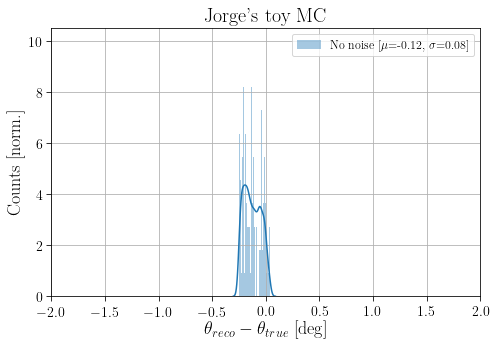

In [15]:
plt.figure(figsize=(7,5))
# plt.hist(delta, bins=100, density=False, alpha=1);
delta_std = (delta).std()
delta_mean = (delta).mean()
sns.distplot((delta),norm_hist=False, bins=500,label = "No noise [$\mu$=%0.2f, $\sigma$=%0.2f]"%(delta_mean, delta_std));

# delta_std = recoNu_noise.deltaTheta.std()
# delta_mean = recoNu_noise.deltaTheta.mean()
# plt.hist(recoNu_noise.deltaTheta, bins=500, density=True, alpha=0.5, color="C1",label = "W/noise [$\mu$=%0.2f, $\sigma$=%0.2f]"%(delta_mean, delta_std));

plt.xlabel("$\\theta_{reco}-\\theta_{true}$ [deg]")
# plt.xlabel("$\\theta$")
plt.ylabel('Counts [norm.]')
plt.title("Jorge's toy MC")
# plt.title("Polarization reconstruction vs. MC truth \n $10^{18}-10^{21}$ eV events ($V_{peak}$+saturation cut)")
# plt.yscale('log')
plt.grid()
plt.legend()
plt.tight_layout()
plt.xlim(-2,2)
# plt.savefig(my_path_plots+'/Dumpster/recoVsTrue_AraSim_noCuts.pdf')
# plt.savefig(my_path_plots+'/Dumpster/recoVsTrueTheta_AraSim_Cuts_noise.png', dpi=150)

In [16]:
deltaPhi = np.array(phiPol_reco)-np.array(phiPol_true)

(-1, 1)

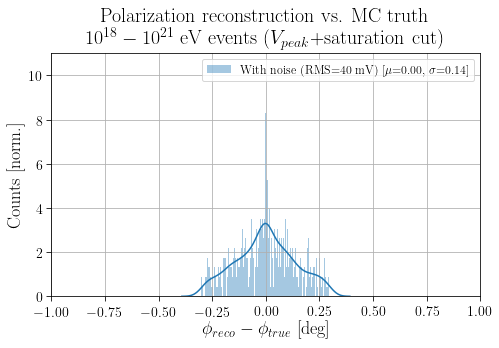

In [18]:
plt.figure(figsize=(7,5))
# plt.hist(delta, bins=100, density=False, alpha=1);
delta_std = (deltaPhi).std()
delta_mean = (deltaPhi).mean()
sns.distplot((deltaPhi),norm_hist=True, bins=500,label = "With noise (RMS=40 mV) [$\mu$=%0.2f, $\sigma$=%0.2f]"%(delta_mean, delta_std));

# delta_std = recoNu_noise.deltaTheta.std()
# delta_mean = recoNu_noise.deltaTheta.mean()
# plt.hist(recoNu_noise.deltaTheta, bins=500, density=True, alpha=0.5, color="C1",label = "W/noise [$\mu$=%0.2f, $\sigma$=%0.2f]"%(delta_mean, delta_std));

plt.xlabel("$\\phi_{reco}-\\phi_{true}$ [deg]")
# plt.xlabel("$\\theta$")
plt.ylabel('Counts [norm.]')
# plt.title("Polarization reconstruction vs. MC truth \n $10^{18}-10^{21}$ eV events (no cuts)")
plt.title("Polarization reconstruction vs. MC truth \n $10^{18}-10^{21}$ eV events ($V_{peak}$+saturation cut)")

# plt.yscale('log')
plt.grid()
plt.legend()
plt.tight_layout()
plt.xlim(-1,1)
# plt.savefig(my_path_plots+'/Dumpster/recoVsTrue_AraSim_noCuts.pdf')
# plt.savefig(my_path_plots+'/Dumpster/recoVsTruePhi_AraSim_Cuts_noise.png', dpi=150)



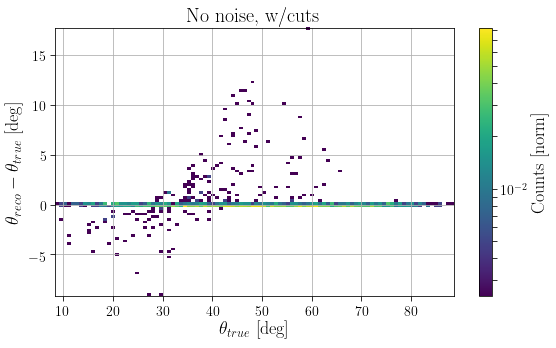

In [61]:
plt.figure(figsize=(8,5))
plt.hist2d(thetaPol_true,delta, bins=100, normed=True,norm=mpl.colors.LogNorm());
# plt.hist2d(90-recoNu_noise.AngStokes,recoNu_noise.AngStokes-recoNu_noise.theta_pol, bins=100, normed=True,norm=mpl.colors.LogNorm());
# plt.title("No noise, no cuts")
plt.title("No noise, w/cuts")
# plt.hist2d(angle_Stokes,angle_Stokes-angle_true)
plt.grid()
plt.colorbar(label="Counts [norm]")
plt.xlabel("$\\theta_{true}$ [deg]")
plt.ylabel("$\\theta_{reco}-\\theta_{true}$ [deg]")
# plt.title("$10^{21}$ eV neutrinos")
plt.tight_layout()

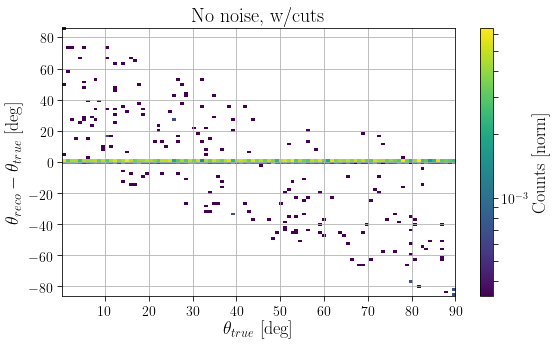

In [62]:
plt.figure(figsize=(8,5))
plt.hist2d(phiPol_true,deltaPhi, bins=100, normed=True,norm=mpl.colors.LogNorm());
# plt.hist2d(90-recoNu_noise.AngStokes,recoNu_noise.AngStokes-recoNu_noise.theta_pol, bins=100, normed=True,norm=mpl.colors.LogNorm());
# plt.title("No noise, no cuts")
plt.title("No noise, w/cuts")
# plt.hist2d(angle_Stokes,angle_Stokes-angle_true)
plt.grid()
plt.colorbar(label="Counts [norm]")
plt.xlabel("$\\theta_{true}$ [deg]")
plt.ylabel("$\\theta_{reco}-\\theta_{true}$ [deg]")
# plt.title("$10^{21}$ eV neutrinos")
plt.tight_layout()

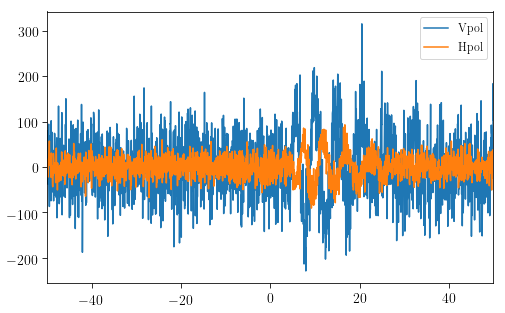

In [63]:
plt.figure(figsize=(8,5))

plt.plot(timeV,voltageV+pyrex.signals.GaussianNoise(timeV,60).values, label="Vpol")
plt.plot(timeH,voltageH+pyrex.signals.GaussianNoise(timeV,20).values, label="Hpol")
# plt.plot(trace.time, trace.traceV, label = "Vpol AraSim")
# plt.plot(trace.time, trace.traceH, label = "Hpol AraSim")
plt.xlim(-50,50)
plt.legend()

In [64]:
wform = pd.read_pickle("./wform_forDebug_PyREx.pkl")


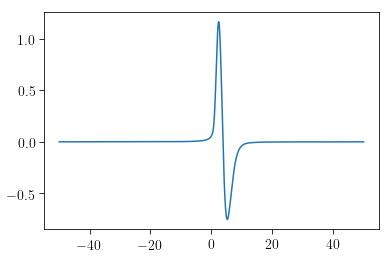

In [5]:
plt.plot(wform.time,wform.voltage)

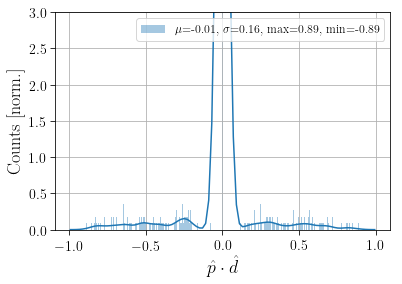

In [84]:
sns.distplot(dot, bins=300,label = "$\mu$=%0.2f, $\sigma$=%0.2f, max=%0.2f, min=%0.2f"%(delta_mean, delta_std, max(dot),min(dot)));
# plt.xlim(-0.5,0.5)
plt.ylim(0,3)
plt.xlabel("$\hat{p}\cdot\hat{d}$")
plt.ylabel("Counts [norm.]")
delta_std = (np.array(dot)).std()
delta_mean = (np.array(dot)).mean()
plt.grid()
plt.legend()

In [9]:
np.degrees(np.arctan2(0.241,0.688))

19.30488295855105

In [8]:
np.degrees(np.arccos(-0.572150))

124.90028828144854